# First Analysis
## Only Offshore wind, no production in Belgium

In [1]:
from gboml import GbomlGraph

timehorizon = 8760


gboml_model = GbomlGraph(timehorizon=timehorizon)
nodes, edges, param = gboml_model.import_all_nodes_and_edges("../../models/base/greenland_simple.gboml")
gboml_model.add_global_parameters(param)
gboml_model.add_nodes_in_model(*nodes)
gboml_model.add_hyperedges_in_model(*edges)
gboml_model.build_model()
solution, obj, status, solver_info, constr_info, _ = gboml_model.solve_gurobi(opt_file="gurobi.txt")
print("Solved")

Check variables of node LIQUEFIED_METHANE_CARRIERS_GR : --- 0.0 seconds ---
Check variables of node LIQUEFIED_METHANE_STORAGE_HUB_GR : --- 0.0 seconds ---
Check variables of node METHANE_LIQUEFACTION_PLANTS_GR : --- 0.0 seconds ---
Check variables of node METHANATION_PLANTS_GR : --- 0.0 seconds ---
Check variables of node WATER_STORAGE_GR : --- 0.0 seconds ---
Check variables of node CARBON_DIOXIDE_STORAGE_GR : --- 0.0 seconds ---
Check variables of node HYDROGEN_STORAGE_GR : --- 0.0 seconds ---
Check variables of node DIRECT_AIR_CAPTURE_PLANTS_GR : --- 0.0 seconds ---
Check variables of node DESALINATION_PLANTS_GR : --- 0.0 seconds ---
Check variables of node ELECTROLYSIS_PLANTS_GR : --- 0.0 seconds ---
Check variables of node HVDC_GR : --- 0.0 seconds ---
Check variables of node BATTERY_STORAGE_GR : --- 0.01563119888305664 seconds ---
Check variables of node ON_WIND_PLANTS_GR : --- 0.0 seconds ---
Check variables of node OFF_WIND_PLANTS_GR : --- 0.0 seconds ---
Check variables of nod

In [2]:
import json

gathered_data = gboml_model.turn_solution_to_dictionary(solver_info, status, solution, obj, constr_info)
print("Json done")
with open(f'../../models/base/results/RREH.json', "w") as fp:json.dump(gathered_data, fp, indent=4)

Json done


In [3]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [4]:
class MakeMeReadable:
    def __init__(self, d):
        self.d = d
    
    def __dir__(self):
        return self.d.keys()
    
    def __getattr__(self, v):
        try:
            out = self.d[v]
            if isinstance(out, dict):
                return MakeMeReadable(out)
            return out
        except:
            return getattr(self.d, v)
        
    def __str__(self):
        return str(self.d)
    
    def __repr__(self):
        return repr(self.d)

In [5]:
dico = {}
with open('../../models/base/results/RREH.json', 'r') as f:
    dico = json.load(f)
            
d = MakeMeReadable(dico)
    
if isinstance(dico, dict):
    print('The data is a dictionary')
else:
    print('The data is not a dictionary')

The data is a dictionary


In [6]:
wind_capacity = d.solution.elements.OFF_WIND_PLANTS_GR.variables.capacity.values
wind_capacity

[32.08339795901533]

In [7]:
def cost_rreh(ls:list):
    if len(ls) == 0:
        return 0.0

    cost = 0

    for ele in ls:
        # print(f"{ele = }")
        # print(dico["solution"]["elements"][ele]["objectives"])
        try:
            cost += np.sum(dico["solution"]["elements"][ele]["objectives"]["unnamed"])
        except:
            for e in dico["solution"]["elements"][ele]["objectives"]["named"].values():
                # print(f"{e = }")
                cost += e
        # print(f"{cost = }")
    
    return cost

In [8]:
def cost_rreh_detailed(ls):
    detailed_cost = {}
    if len(ls) == 0:
        return detailed_cost

    for ele in ls:
        node_cost = 0
        try:
            node_cost += np.sum(dico["solution"]["elements"][ele]["objectives"]["unnamed"])
        except:
            for e in dico["solution"]["elements"][ele]["objectives"]["named"].values():
                node_cost += e
        detailed_cost[ele] = node_cost
    
    return detailed_cost


In [9]:
ls_nodes = list(d.model.nodes.keys())

print(ls_nodes)

['LIQUEFIED_METHANE_CARRIERS_GR', 'LIQUEFIED_METHANE_STORAGE_HUB_GR', 'METHANE_LIQUEFACTION_PLANTS_GR', 'METHANATION_PLANTS_GR', 'WATER_STORAGE_GR', 'CARBON_DIOXIDE_STORAGE_GR', 'HYDROGEN_STORAGE_GR', 'DIRECT_AIR_CAPTURE_PLANTS_GR', 'DESALINATION_PLANTS_GR', 'ELECTROLYSIS_PLANTS_GR', 'HVDC_GR', 'BATTERY_STORAGE_GR', 'ON_WIND_PLANTS_GR', 'OFF_WIND_PLANTS_GR', 'ENERGY_DEMAND_BE', 'LIQUEFIED_METHANE_STORAGE_DESTINATION', 'LIQUEFIED_METHANE_REGASIFICATION']


In [10]:
try:
    GR_nodes = list(map(lambda string: string if string[-3:] == "_GR" else None, ls_nodes))
except:
    GR_nodes = []
BE_nodes = list(map(lambda string: string if string[-3:] == "_BE" or string in ["PCCC_CCGT", "PCCC", "CO2_EXPORT", "LIQUEFIED_METHANE_STORAGE_DESTINATION","LIQUEFIED_METHANE_REGASIFICATION"] else None, ls_nodes))

try:
    GR_nodes = list(filter(lambda x: x not in [None, "PCCC", "PROD_CO2", "CO2_EXPORT"], GR_nodes))
except:
    GR_nodes = []
BE_nodes = list(filter(lambda x: x not in [None, "PROD_CO2"], BE_nodes))

cost_GR = cost_rreh(GR_nodes)
cost_BE = cost_rreh(BE_nodes)


print(f"GR {cost_GR = }")
print(f"BE {cost_BE = }")


obj_cost = d.solution.objective
tot_cost = np.sum([cost_GR, cost_BE])

abs_diff = np.abs(d.solution.objective - np.sum([cost_GR, cost_BE]))
print(f"{obj_cost = }")
print(f"{tot_cost = }")
print(abs_diff < 0.1)

GR cost_GR = 27989.527338632633
BE cost_BE = 730.9522689928597
obj_cost = 28720.479607624377
tot_cost = 28720.479607625493
True


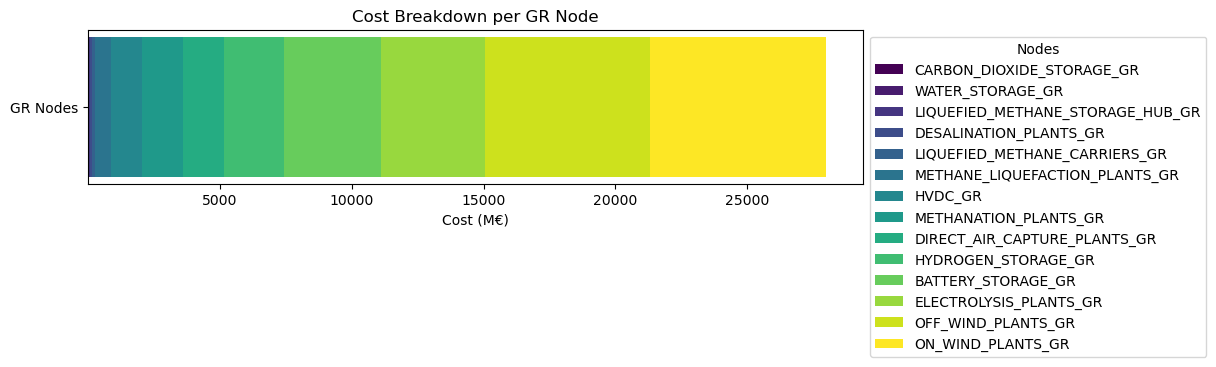

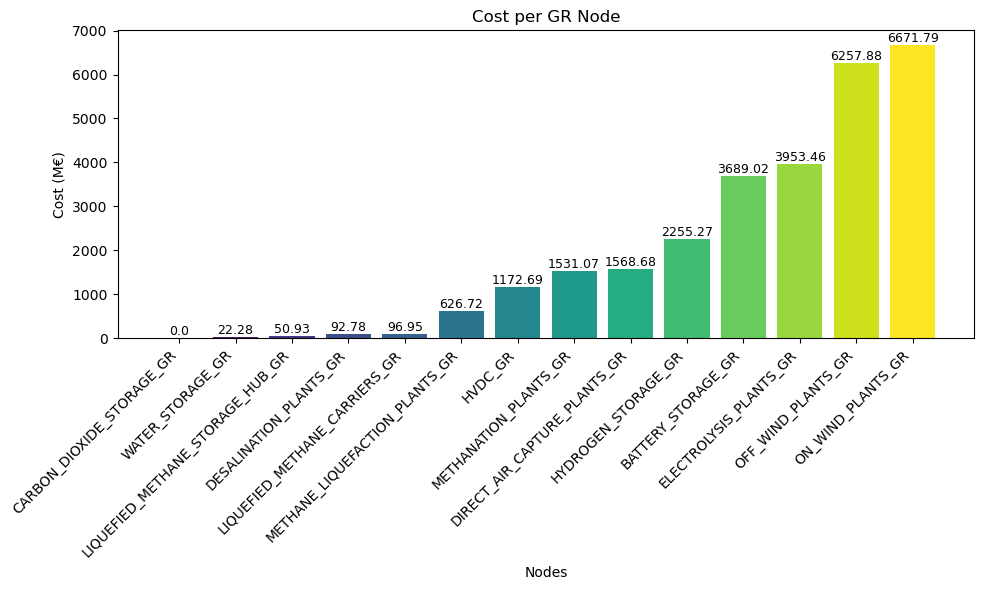

In [28]:
import matplotlib.pyplot as plt
import numpy as np

cost_details_GR = cost_rreh_detailed(GR_nodes)

sorted_nodes_and_costs = sorted(cost_details_GR.items(), key=lambda item: item[1])
sorted_nodes = [item[0] for item in sorted_nodes_and_costs]
sorted_costs = [item[1] for item in sorted_nodes_and_costs]

# Generate colors - ensuring consistent colors across plots
colors = plt.cm.viridis(np.linspace(0, 1, len(sorted_nodes)))

# Plot 1: Stacked Horizontal Bar Chart
plt.figure(figsize=(10, 2))
cumulative_cost = 0  # Start at 0 for the leftmost bar segment

for node, cost, color in zip(sorted_nodes, sorted_costs, colors):
    plt.barh('GR Nodes', cost, left=cumulative_cost, color=color, label=node)
    cumulative_cost += cost

plt.xlabel('Cost (M€)')
plt.title('Cost Breakdown per GR Node')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1), title='Nodes')
plt.show()

# Plot 2: Vertical Bar Chart with Sorted Nodes
plt.figure(figsize=(10, 6))
bars = plt.bar(sorted_nodes, sorted_costs, color=colors)

plt.xlabel('Nodes')
plt.ylabel('Cost (M€)')
plt.title('Cost per GR Node')
plt.xticks(rotation=45, ha="right")

# Adding the cost above each bar
for bar, cost in zip(bars, sorted_costs):
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval, round(cost, 2), ha='center', va='bottom', fontsize=9)

plt.tight_layout()  # Adjust layout to make room for the rotated x-axis labels
plt.show()

In [19]:
wind_onshore_gr = d.solution.elements.ON_WIND_PLANTS_GR.variables.capacity.values[0]
wind_off_gr = d.solution.elements.OFF_WIND_PLANTS_GR.variables.capacity.values[0]

total_installed_capacity = wind_onshore_gr + wind_off_gr

Installed capacity of onshore = 42.89881108693037 GW
Installed capacity of offshore = 32.08339795901533 GW
Total installed capacity = 74.9822090459457 GW


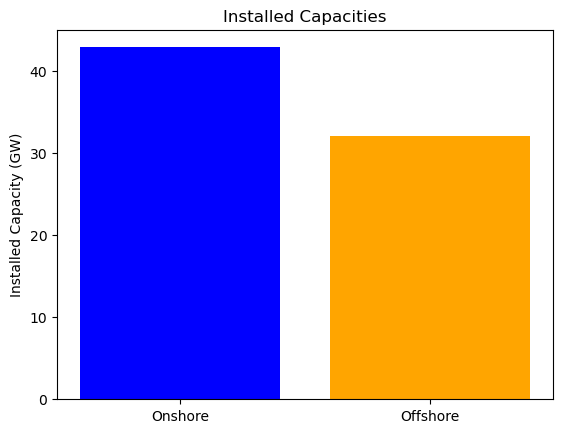

In [20]:
# Print the installed capacities and total
print(f"Installed capacity of onshore = {wind_onshore_gr} GW")
print(f"Installed capacity of offshore = {wind_off_gr} GW")
print(f"Total installed capacity = {total_installed_capacity} GW")

# Plotting
labels = ['Onshore', 'Offshore']
values = [wind_onshore_gr, wind_off_gr]

plt.bar(labels, values, color=['blue', 'orange'])
plt.ylabel('Installed Capacity (GW)')
plt.title('Installed Capacities')
plt.show()

Text(0.5, 1.0, 'Electricity produced')

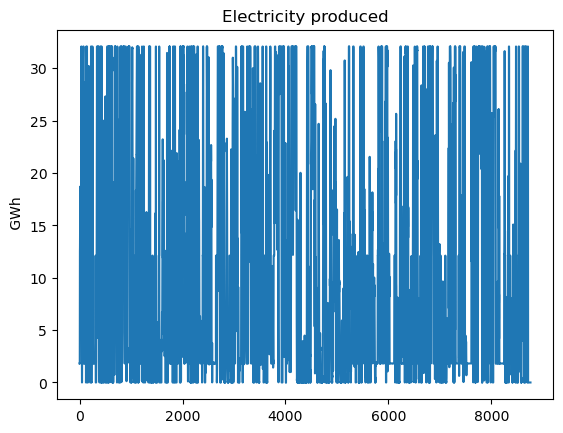

In [21]:
wind_prod = d.solution.elements.OFF_WIND_PLANTS_GR.variables.electricity.values
plt.plot(wind_prod)
plt.ylabel(' GWh')
plt.title('Electricity produced')

In [24]:
gas_demand = d.model.hyperedges.DESTINATION_METHANE_BALANCE.parameters.demand
gas_demand = np.sum(gas_demand[:8760])/1000
print("the gas demand is ", gas_demand, "TWh")

the gas demand is  131.148729 TWh


In [26]:
demand_in_mwh = gas_demand * 1e6  # Convert TWh to MWh
total_cost_in_euros = tot_cost * 1e6  # Convert million euros to euros

# Compute price per MWh in euros
price_per_mwh = total_cost_in_euros / demand_in_mwh

print(f"The price is {round(price_per_mwh, 3)} €/MWh \n")
print("In February 2024, the natural gas price is between 40.2 and 51.5 €/MWh")  # Adjusted to €/MWh
print("This system is about", round((price_per_mwh / 45), 3), "times more expensive compared to a reference price of 45 €/MWh")

The price is 218.992 €/MWh 

In February 2024, the natural gas price is between 40.2 and 51.5 €/MWh
This system is about 4.866 times more expensive compared to a reference price of 45 €/MWh


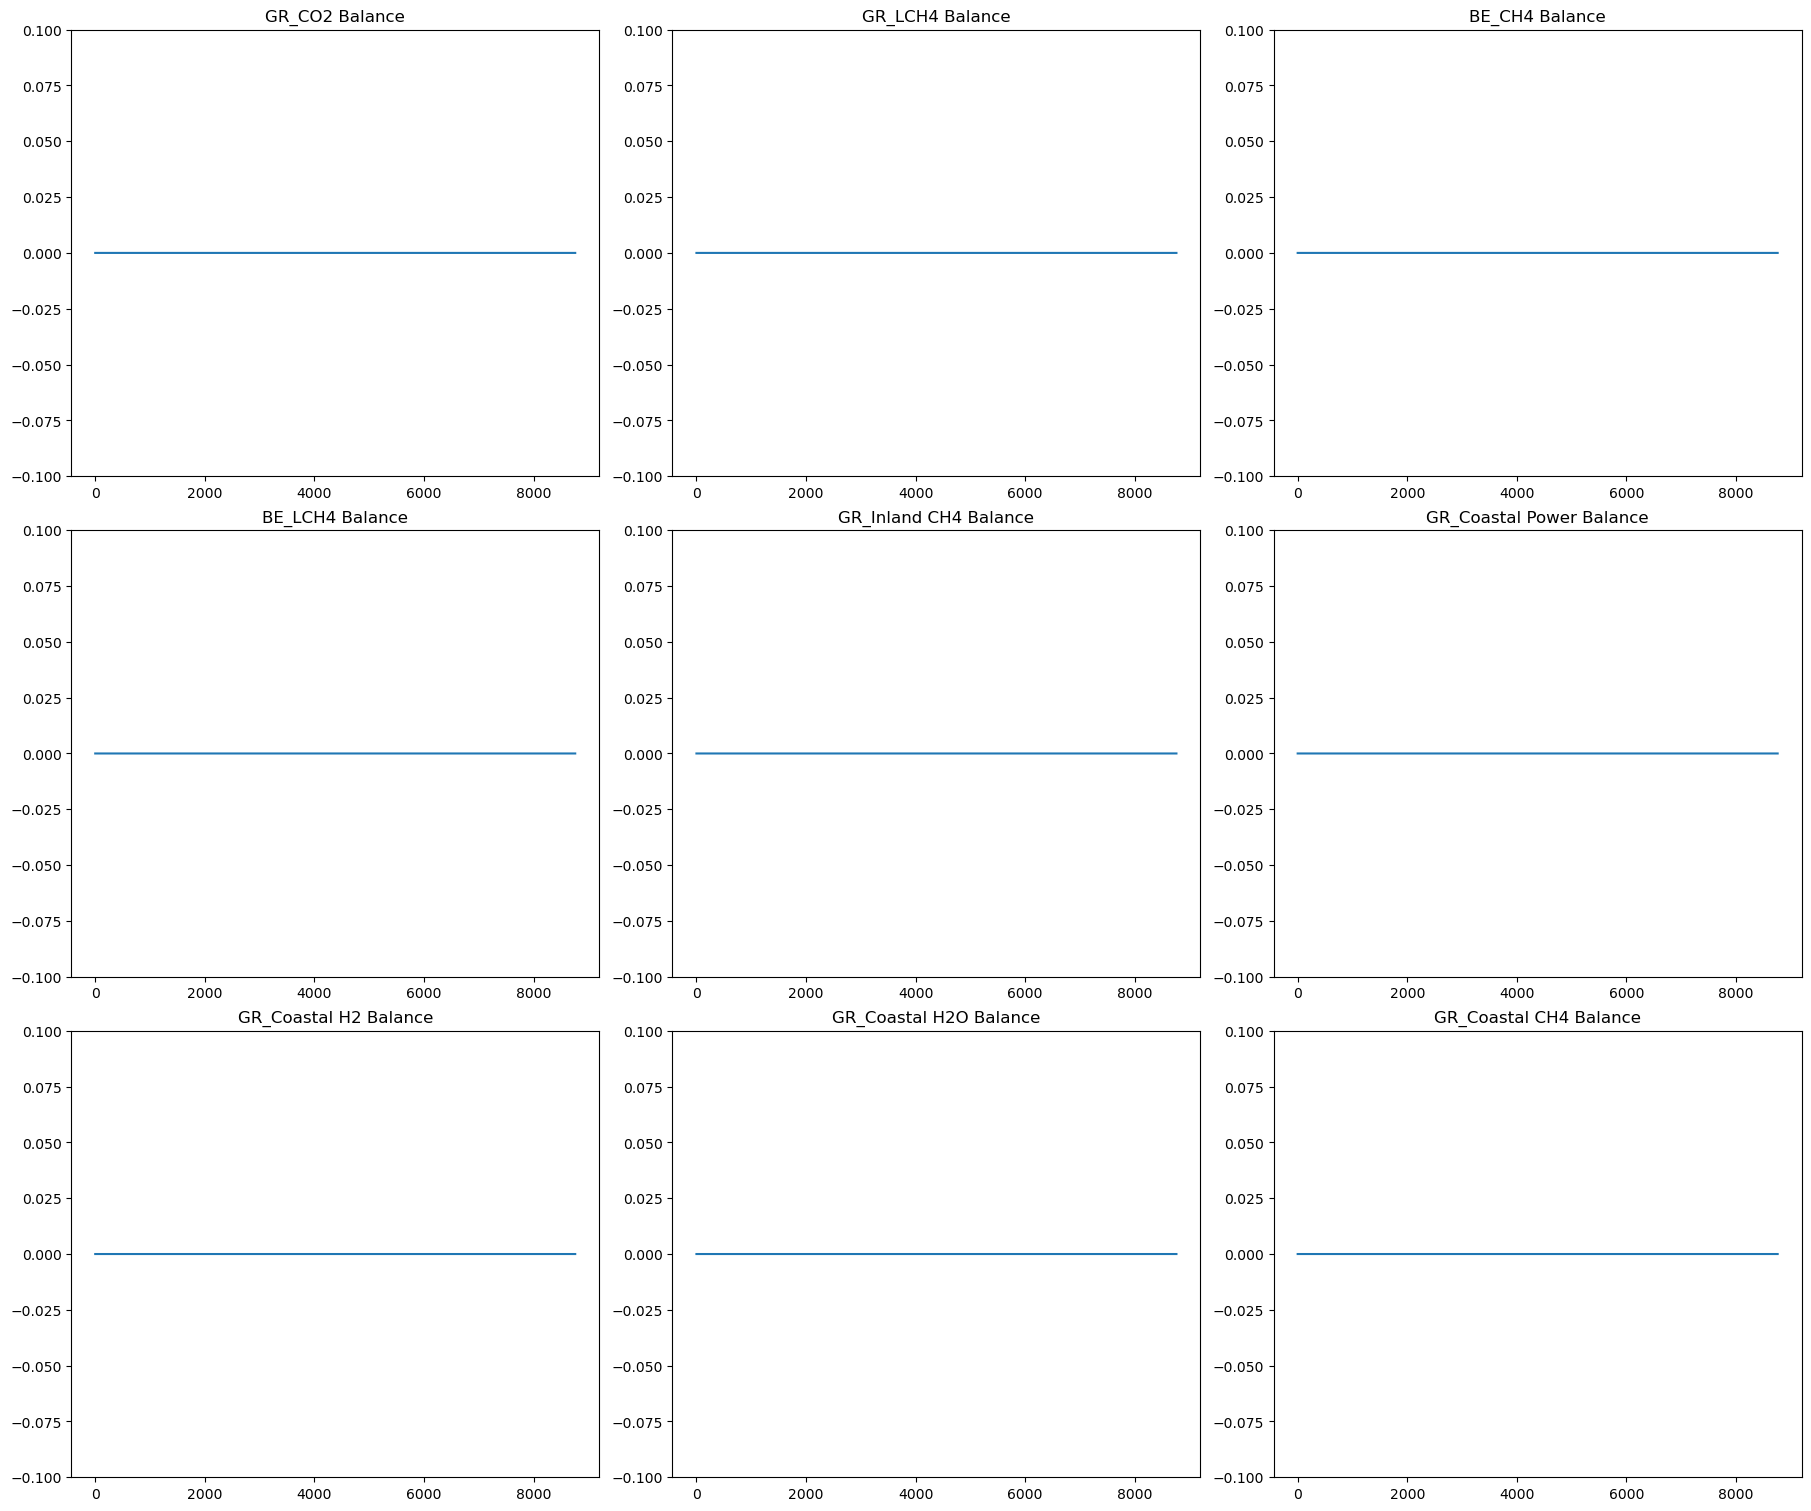

In [48]:
import matplotlib.pyplot as plt
import numpy as np

fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(18, 15), constrained_layout=True)
ylim = (-0.1, 0.1)
axs = axs.flatten()
def plot_balance(ax, data, title):
    ax.plot(data)
    ax.set_ylim(ylim)
    ax.set_title(title)
    
# GR_CO2 Balance
co2_storage_gr_in = np.array(d.solution.elements.CARBON_DIOXIDE_STORAGE_GR.variables.carbon_dioxide_in.values)
co2_storage_gr_out = np.array(d.solution.elements.CARBON_DIOXIDE_STORAGE_GR.variables.carbon_dioxide_out.values)
dac_gr = np.array(d.solution.elements.DIRECT_AIR_CAPTURE_PLANTS_GR.variables.carbon_dioxide.values)
methanation_gr = np.array(d.solution.elements.METHANATION_PLANTS_GR.variables.carbon_dioxide.values)
co2_balance_gr = dac_gr + co2_storage_gr_out - co2_storage_gr_in - methanation_gr

plot_balance(axs[0], co2_balance_gr, 'GR_CO2 Balance')

# GR_LCH4 Balance
lch4_carriers_gr = np.array(d.solution.elements.LIQUEFIED_METHANE_CARRIERS_GR.variables.liquefied_methane_in.values)
lch4_storage_gr_in = np.array(d.solution.elements.LIQUEFIED_METHANE_STORAGE_HUB_GR.variables.liquefied_methane_in.values)
lch4_storage_gr_out = np.array(d.solution.elements.LIQUEFIED_METHANE_STORAGE_HUB_GR.variables.liquefied_methane_out.values)
ch4_liquefaction_gr = np.array(d.solution.elements.METHANE_LIQUEFACTION_PLANTS_GR.variables.liquefied_methane.values)
lch4_balance_gr = ch4_liquefaction_gr + lch4_storage_gr_out - lch4_storage_gr_in - lch4_carriers_gr

plot_balance(axs[1], lch4_balance_gr, 'GR_LCH4 Balance')

# Check BE_CH4 Balance
conversion_factor = d.model.hyperedges.DESTINATION_METHANE_BALANCE.parameters.conversion_factor
demand_CH4 = np.array(d.model.hyperedges.DESTINATION_METHANE_BALANCE.parameters.demand)
lch4_regasification_be = np.array(d.solution.elements.LIQUEFIED_METHANE_REGASIFICATION.variables.methane.values)
ch4_balance_be = conversion_factor * lch4_regasification_be - demand_CH4[:timehorizon]

plot_balance(axs[2], ch4_balance_be, 'BE_CH4 Balance')


# Check BE_LCH4 Balance
lch4_carriers_gr = np.array(d.solution.elements.LIQUEFIED_METHANE_CARRIERS_GR.variables.liquefied_methane_out.values)
lch4_storage_dest_in = np.array(d.solution.elements.LIQUEFIED_METHANE_STORAGE_DESTINATION.variables.liquefied_methane_in.values)
lch4_storage_dest_out = np.array(d.solution.elements.LIQUEFIED_METHANE_STORAGE_DESTINATION.variables.liquefied_methane_out.values)
lch4_regasification_be = np.array(d.solution.elements.LIQUEFIED_METHANE_REGASIFICATION.variables.liquefied_methane.values)
lch4_balance_be = lch4_carriers_gr + lch4_storage_dest_out - lch4_storage_dest_in - lch4_regasification_be

plot_balance(axs[3], lch4_balance_be, 'BE_LCH4 Balance')


# Check GR_INLAND CH4 Balance
off_wind_gr = np.array(d.solution.elements.OFF_WIND_PLANTS_GR.variables.electricity.values)
on_wind_gr = np.array(d.solution.elements.ON_WIND_PLANTS_GR.variables.electricity.values)
battery_storage_gr_out = np.array(d.solution.elements.BATTERY_STORAGE_GR.variables.electricity_out.values)
battery_storage_gr_in = np.array(d.solution.elements.BATTERY_STORAGE_GR.variables.electricity_in.values)
hvdc_gr_in = np.array(d.solution.elements.HVDC_GR.variables.electricity_in.values)
power_balance_gr = off_wind_gr + on_wind_gr + battery_storage_gr_out - battery_storage_gr_in - hvdc_gr_in

plot_balance(axs[4], power_balance_gr, 'GR_Inland CH4 Balance')


# Check GR_Coastal Power Balance
hvdc_gr_out = np.array(d.solution.elements.HVDC_GR.variables.electricity_out.values)
electrolysis_gr = np.array(d.solution.elements.ELECTROLYSIS_PLANTS_GR.variables.electricity.values)
h2_storage_gr = np.array(d.solution.elements.HYDROGEN_STORAGE_GR.variables.electricity.values)
desalination_gr = np.array(d.solution.elements.DESALINATION_PLANTS_GR.variables.electricity.values)
h2o_storage_gr = np.array(d.solution.elements.WATER_STORAGE_GR.variables.electricity.values)
co2_storage_gr = np.array(d.solution.elements.CARBON_DIOXIDE_STORAGE_GR.variables.electricity.values)
ch4_liquefaction_gr = np.array(d.solution.elements.METHANE_LIQUEFACTION_PLANTS_GR.variables.electricity.values)
dac_gr = np.array(d.solution.elements.DIRECT_AIR_CAPTURE_PLANTS_GR.variables.electricity.values)
power_balance_gr = hvdc_gr_out - electrolysis_gr - h2_storage_gr - desalination_gr - h2o_storage_gr - co2_storage_gr - ch4_liquefaction_gr - dac_gr 

plot_balance(axs[5], power_balance_gr, 'GR_Coastal Power Balance')


# Check GR_Coastal H2 Balance
electrolysis_gr = np.array(d.solution.elements.ELECTROLYSIS_PLANTS_GR.variables.hydrogen.values)
h2_storage_gr_out = np.array(d.solution.elements.HYDROGEN_STORAGE_GR.variables.hydrogen_out.values)
h2_storage_gr_in = np.array(d.solution.elements.HYDROGEN_STORAGE_GR.variables.hydrogen_in.values)
methanation_gr = np.array(d.solution.elements.METHANATION_PLANTS_GR.variables.hydrogen.values)
dac_gr = np.array(d.solution.elements.DIRECT_AIR_CAPTURE_PLANTS_GR.variables.hydrogen.values)
h2_balance_gr = electrolysis_gr + h2_storage_gr_out - h2_storage_gr_in - methanation_gr - dac_gr

plot_balance(axs[6], h2_balance_gr, 'GR_Coastal H2 Balance')


# Check GR_Coastal H2O Balance
desalination_gr = np.array(d.solution.elements.DESALINATION_PLANTS_GR.variables.water.values)
methanation_gr = np.array(d.solution.elements.METHANATION_PLANTS_GR.variables.water.values)
h2o_storage_gr_out = np.array(d.solution.elements.WATER_STORAGE_GR.variables.water_out.values)
h2o_storage_gr_in = np.array(d.solution.elements.WATER_STORAGE_GR.variables.water_in.values)
electrolysis_gr = np.array(d.solution.elements.ELECTROLYSIS_PLANTS_GR.variables.water.values)
dac_gr = np.array(d.solution.elements.DIRECT_AIR_CAPTURE_PLANTS_GR.variables.water.values)
h20_balance_gr = desalination_gr + methanation_gr + h2o_storage_gr_out - h2o_storage_gr_in - electrolysis_gr - dac_gr

plot_balance(axs[7], h20_balance_gr, 'GR_Coastal H2O Balance')

# Check GR_Coastal CH4 Balance
methanation_gr = np.array(d.solution.elements.METHANATION_PLANTS_GR.variables.methane.values)
ch4_liquefaction_gr = np.array(d.solution.elements.METHANE_LIQUEFACTION_PLANTS_GR.variables.liquefied_methane.values)
ch4_balance_gr = methanation_gr - ch4_liquefaction_gr

plot_balance(axs[8], ch4_balance_gr, 'GR_Coastal CH4 Balance')

plt.show()